The first 5 rows of the dataset:
   satisfaction_level  last_evaluation  ...  sales  salary
0                0.38             0.53  ...  sales     low
1                0.80             0.86  ...  sales  medium
2                0.11             0.88  ...  sales  medium
3                0.72             0.87  ...  sales     low
4                0.37             0.52  ...  sales     low

[5 rows x 10 columns]
general info about the columsn of the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left         

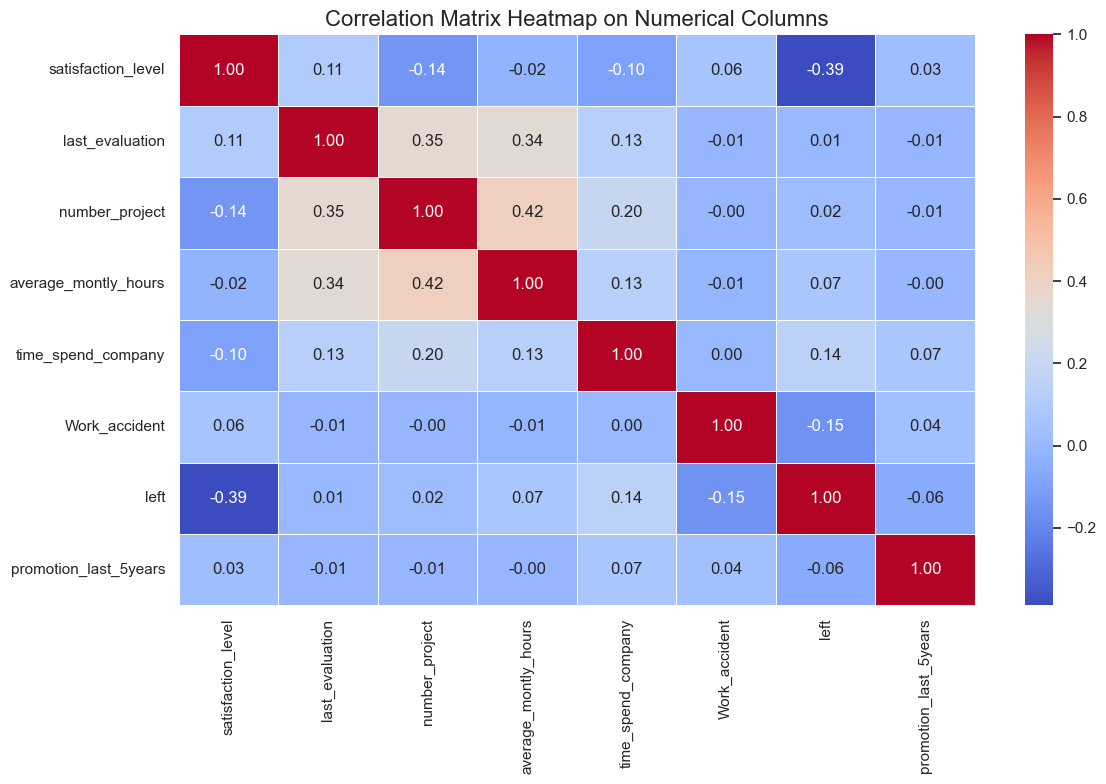

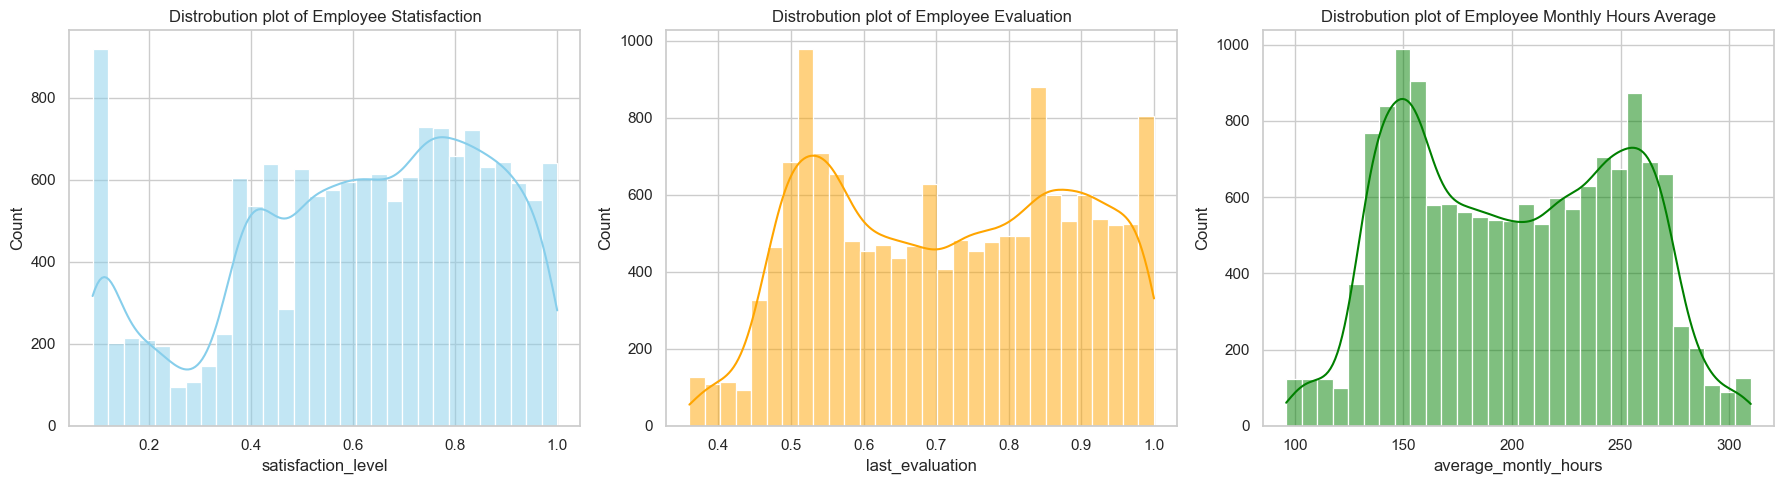

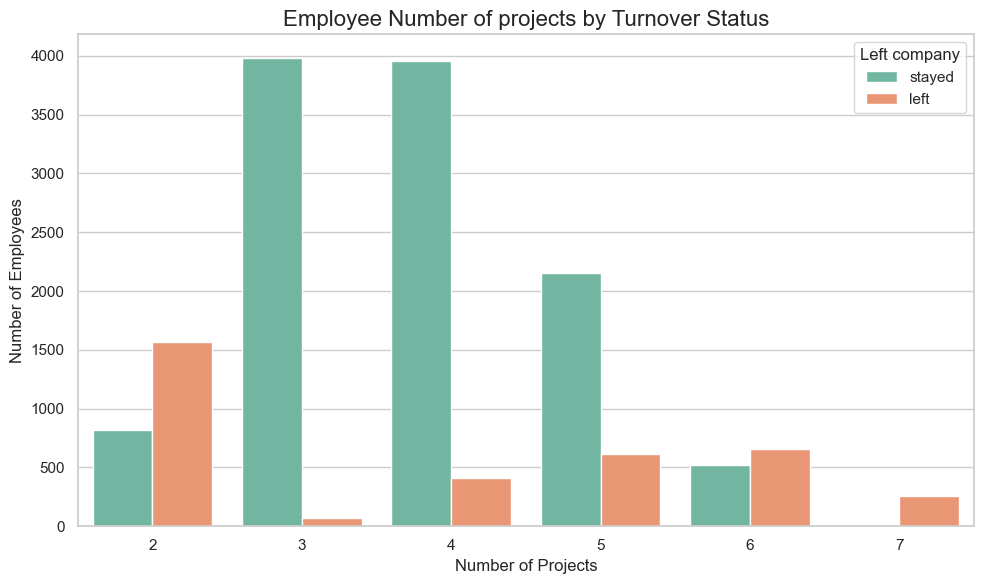

In [135]:
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from collections import Counter
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier



from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score




#loading the dataset as a dataframe
df = pd.read_csv('employee_turnover.csv')

# view the first 5 rows of the dataset
print('The first 5 rows of the dataset:')
print(df.head())

# show general info about the columns, non-null (not empty) counts, and data types
print('general info about the columsn of the dataset:')
print(df.info())

#compute correlation matrix for numerical columns only
correlation_matrix_number_columns = df.corr(numeric_only=True)

#Setting up matplotlib figure
plt.figure(figsize=(12,8))

#creating the heatmap on the numerical columns
sns.heatmap(correlation_matrix_number_columns, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# naming the title : Correlation-Matrix Heatmap of Numerical Features
plt.title('Correlation Matrix Heatmap on Numerical Columns', fontsize=16)

#Displaying
plt.tight_layout()
plt.show()


# Creating Distribution plot for the 3 columns

# first set style for seaborn
sns.set_theme(style="whitegrid")

#creating the number of subplots
plt.figure(figsize=(18,5))

# 1 Statisfaction_level plot
plt.subplot(1,3,1)
sns.histplot(df['satisfaction_level'], kde=True, bins=30, color='skyblue')
plt.title('Distrobution plot of Employee Statisfaction')


# 2 last_evaluation plot
plt.subplot(1,3,2)
sns.histplot(df['last_evaluation'], kde=True, bins=30, color='orange')
plt.title('Distrobution plot of Employee Evaluation')

# 3 Average Monthly hours of the Employee
plt.subplot(1,3,3)
sns.histplot(df['average_montly_hours'], kde=True, bins=30, color='green' )
plt.title('Distrobution plot of Employee Monthly Hours Average')
plt.tight_layout()
plt.show()

# Bar plot of Employee project count for who left and who stayed

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='number_project', hue='left', palette='Set2')

# Add axises labels and title
plt.title('Employee Number of projects by Turnover Status', fontsize=16)
plt.xlabel('Number of Projects')
plt.ylabel('Number of Employees')
plt.legend(title='Left company', labels=['stayed', 'left'])

plt.tight_layout()
plt.show()







Inferences about the bar the plot:
- Employees that stayed and had 2 projects could have been new
- Employees that left and had 2 projects could have been bored, or did not like the projects

- Most employees who had 3 projects may have enjoyed that project, there was a small percentage who left afterwards

- Around 6-7 projects a little percentage of employees stayed, but it seems like most got tired or bored at the job

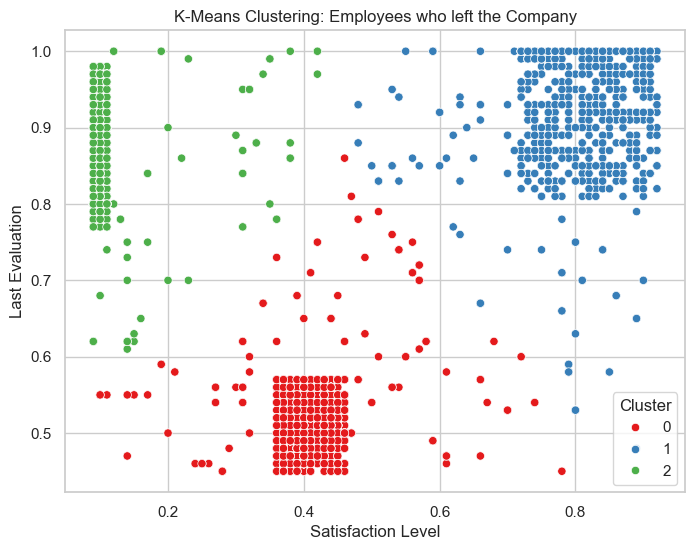

In [136]:
#Using K-means to group employees based on who left based on satisfaction and evaluation 

#filtering on only the employees that left the company
left_company = df[df['left'] == 1]

#setting satisfaction level and last evaluation columns to X
X = left_company[['satisfaction_level', 'last_evaluation']]

#making the K-means cluster
kmeans = KMeans(n_clusters=3, random_state=42)
left_company = left_company.copy()
left_company['cluster'] = kmeans.fit_predict(X)

#showing the K-means cluster
plt.figure(figsize=(8,6))
sns.scatterplot(data=left_company, x='satisfaction_level', y='last_evaluation',hue='cluster', palette='Set1')

plt.title('K-Means Clustering: Employees who left the Company')
plt.xlabel('Satisfaction Level')
plt.ylabel('Last Evaluation')
plt.legend(title='Cluster')
plt.show()


My thoughts on the K-Means clusters of the employees that left based on their Satisfaction and Last Evaluation:

- The Red cluster is showing employees that left that had a lower satisfaction level and low evaluation level, meaning that they were most likely underperforming

- The Blue cluster is showing employees that left that had a high satisfaction level and a high evaluation level, meaning that they were high performers that were most likely being over worked and/or unrecognized.

- The Green cluster is showing employees that left that had a high last evaluation but a low satisfaction level, meaning that they were hard workers but were most likely unhappy with the job 

In [137]:
#Using SMOTE to balance out the number of Employees that left 

#Defining features and target, droping the left column from the dataset
drop_left_column = df.drop('left', axis=1)
predict_left_column = df['left']

# identifying only objects and categories for left column
categorical_cols = drop_left_column.select_dtypes(include=["object", "category"]).columns.tolist()

#identifying only numerical columns
numerical_cols = drop_left_column.select_dtypes(include=["int64", "float64"]).columns.tolist()

#create new dataframes with only categorical and numeric columns
drop_left_column_categorical = drop_left_column[categorical_cols]
drop_left_column_numerical = drop_left_column[numerical_cols]

#applying get_dummies to categorical data
dummies_categorical = pd.get_dummies(drop_left_column_categorical, drop_first=True)

#combining the new datasets
combine_dummies = pd.concat([drop_left_column_numerical, dummies_categorical], axis=1)

#Train/split test for 80 percent training and 20 percent test

#stratified split
X_train,X_test,y_train,y_test = train_test_split(
    combine_dummies,
    predict_left_column,
    test_size=0.2,
    stratify=predict_left_column,
    random_state=123
    
)

#applying smote
smote = SMOTE(random_state=123)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

#showing the unbalanced dataset vs new balanced dataset
print('Unbalanced Dataset:', Counter(y_train))
print('Balanced Dataset:'), Counter(y_train_resampled)




Unbalanced Dataset: Counter({0: 9142, 1: 2857})
Balanced Dataset:


(None, Counter({0: 9142, 1: 9142}))

              precision    recall  f1-score   support

      Stayed       0.81      0.77      0.79      9142
        Left       0.78      0.82      0.80      9142

    accuracy                           0.80     18284
   macro avg       0.80      0.80      0.80     18284
weighted avg       0.80      0.80      0.80     18284



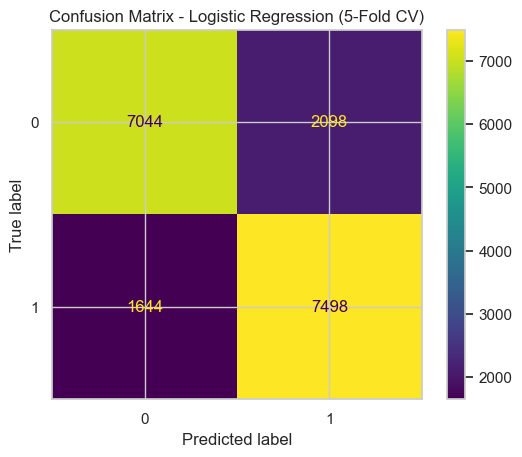

In [138]:
#5-fold cross-validation model training and evaluate performance for Logical regression model
log_reg = LogisticRegression(max_iter=1000, random_state=123)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

#applying 5-fold CV
y_pred = cross_val_predict(log_reg, X_train_resampled, y_train_resampled, cv=cv)

#print the report
print(classification_report(y_train_resampled, y_pred, target_names=["Stayed", "Left"]))

# Plotting
ConfusionMatrixDisplay.from_predictions(y_train_resampled, y_pred)
plt.title("Confusion Matrix - Logistic Regression (5-Fold CV)")
plt.show()

              precision    recall  f1-score   support

      Stayed       0.98      1.00      0.99      9142
        Left       1.00      0.97      0.98      9142

    accuracy                           0.98     18284
   macro avg       0.99      0.98      0.98     18284
weighted avg       0.99      0.98      0.98     18284



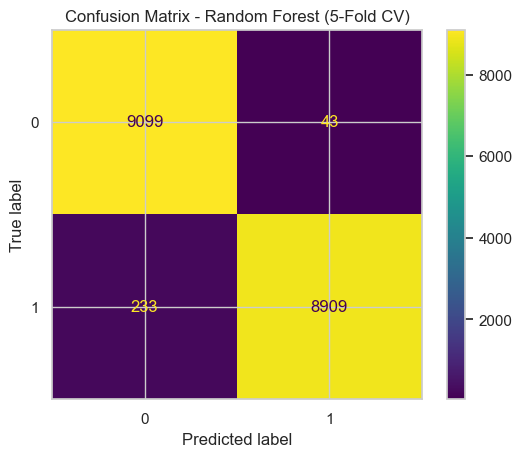

In [139]:
#5 -fold cross-validation model training and evaluate performance for Random Forest Classifier model 
rf_model = RandomForestClassifier(n_estimators=100, random_state=123)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# applying the 5 fold cross validation
y_pred_rf = cross_val_predict(rf_model, X_train_resampled, y_train_resampled, cv=cv)

#print the classification report
print(classification_report(y_train_resampled, y_pred_rf, target_names=["Stayed", "Left"]))

#Make the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_train_resampled, y_pred_rf)
plt.title("Confusion Matrix - Random Forest (5-Fold CV)")
plt.show()



              precision    recall  f1-score   support

      Stayed       0.95      0.98      0.96      9142
        Left       0.98      0.95      0.96      9142

    accuracy                           0.96     18284
   macro avg       0.96      0.96      0.96     18284
weighted avg       0.96      0.96      0.96     18284



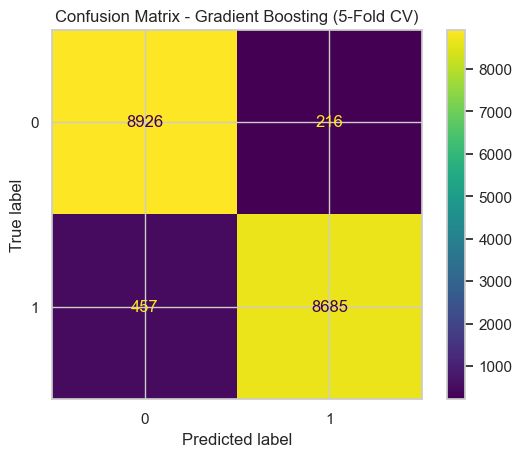

In [140]:
#5 -fold cross-validation model training and evaluate performance for Gradient Boosting model 
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=123)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

#Perform 5 fold cross validation
y_pred_gb = cross_val_predict(gb_model, X_train_resampled, y_train_resampled, cv=cv)

#the report
print(classification_report(y_train_resampled, y_pred_gb, target_names=["Stayed", "Left"]))

#confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_train_resampled, y_pred_gb)
plt.title("Confusion Matrix - Gradient Boosting (5-Fold CV)")
plt.show()


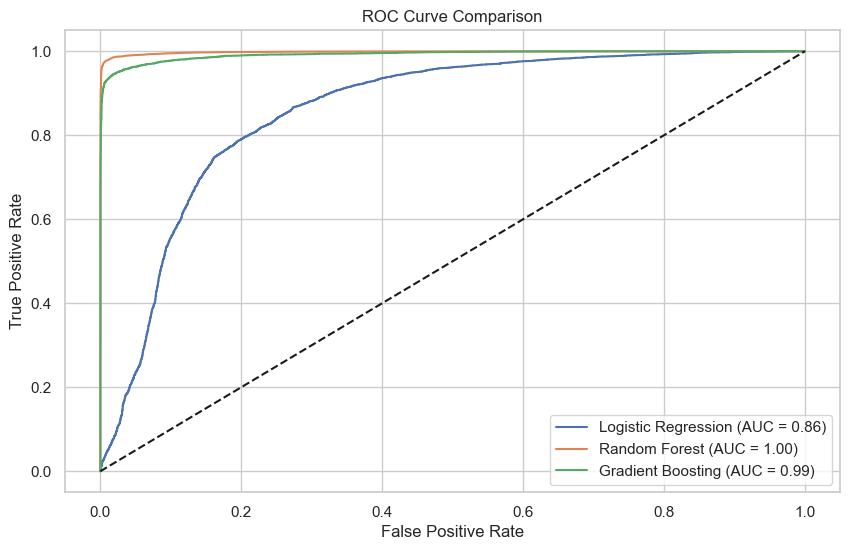

In [141]:

# Step 1: Get Probabilities (cross_val_predict with method='predict_proba')
y_proba_lr = cross_val_predict(log_reg, X_train_resampled, y_train_resampled, cv=5, method='predict_proba')[:, 1]
y_proba_rf = cross_val_predict(rf_model, X_train_resampled, y_train_resampled, cv=5, method='predict_proba')[:, 1]
y_proba_gb = cross_val_predict(gb_model, X_train_resampled, y_train_resampled, cv=5, method='predict_proba')[:, 1]

# Step 2: Compute ROC curve and AUC
fpr_lr, tpr_lr, _ = roc_curve(y_train_resampled, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_train_resampled, y_proba_rf)
fpr_gb, tpr_gb, _ = roc_curve(y_train_resampled, y_proba_gb)

auc_lr = auc(fpr_lr, tpr_lr)
auc_rf = auc(fpr_rf, tpr_rf)
auc_gb = auc(fpr_gb, tpr_gb)

# Step 3: Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})")
plt.plot(fpr_gb, tpr_gb, label=f"Gradient Boosting (AUC = {auc_gb:.2f})")

# Plot settings
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line for random guessing
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Question: Explain which metric needs to be used from the confusion matrix: Recall or Precision? 
- RECALL: If we focused on just using the recall, then we would most likely recieve both some false positives and negatives and miss out on who is actually about to leave. 

- PRECISION: Would garentee that we are right about who is actually about to leave, but dont know if we missed anyone. 

my option: would be choosing RECALL because missing someone who likely to leave is worse than falsely assume someone is leaving but they arent

In [142]:
# Predict Turnover Probabilities on using the Gradient boosting model
gb_model.fit(X_train_resampled, y_train_resampled)

#predict probs of all that are leaving
y_test_proba = gb_model.predict_proba(X_test)[:, 1]

# create a dataframe
risk_df = X_test.copy()
risk_df['Turnover_Probability'] = y_test_proba

# categorizing employees into zones
def categorize_risk(prob):
    if prob < 0.20:
        return 'Safe Zone (Green)'
    elif 0.20 <= prob < 0.60:
        return 'Low-Risk Zone (Yellow)'
    elif 0.60 <= prob < 0.90:
        return 'Medium-Risk Zone (Orange)'
    else:
        return 'High-Risk Zone (Red)'

risk_df['Risk_Zone'] = risk_df['Turnover_Probability'].apply(categorize_risk)
zone_counts = risk_df['Risk_Zone'].value_counts()
print(zone_counts)


Risk_Zone
Safe Zone (Green)            2091
High-Risk Zone (Red)          616
Low-Risk Zone (Yellow)        210
Medium-Risk Zone (Orange)      83
Name: count, dtype: int64


- retention strategies for each zone based on their probability of leaving
Safe Zone:

Continue to monitor engagement, maintain morale, offer regular feedback and recognition. These employees are stable.

Low risk zone:

Provide periodic check-ins, discuss career growth. Some may become medium risk due to unmet expectations.

medium risk zone:
Identify concerns via surveys or 1-on-1s. Offer training, flexible work options, and manager support. Act before they move into red.


high risk zone: 

Prioritize immediate action. Escalate to leadership if needed. Offer retention bonuses, meaningful roles, mentorship, or workload relief. 